# ANALYSIS

In [ ]:
#uncomment this below code to install imblearn package
# !pip install imbalanced-learn

In [1]:
import pandas as pd
import numpy as np
import sklearn

#statistics
from scipy.stats import chi2_contingency, ttest_ind

import cudf #gpu-powered DataFrame (Pandas alternative)

#imbalance handling
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, RepeatedEditedNearestNeighbours
from imblearn.pipeline import Pipeline

#preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder, MinMaxScaler

#internal validation
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedStratifiedKFold, cross_val_score, GridSearchCV, PredefinedSplit

#performance metrices
from sklearn.metrics import confusion_matrix, classification_report, f1_score, balanced_accuracy_score, matthews_corrcoef, auc, average_precision_score, roc_auc_score, balanced_accuracy_score, roc_curve, accuracy_score

#Models selection
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from cuml.svm import SVC #gpu-powered SVM



#save and load trained model
import pickle

#visualisation
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter


In [2]:
# Data loader
features = pd.read_csv("../mimic_data/master_dataset.csv")
# outcomes = pd.read_csv("../FinalData/data_outcomes_10072023.csv")
# outcomes = outcomes[outcomes.columns[1:]]

In [3]:
masterData = features.groupby('subject_id').first()
masterData.reset_index(inplace=True, drop=True)

In [4]:
outcomes = ['outcome_inhospital_mortality', 'outcome_ed_revisit_30d', 'outcome_icu_transfer_12h'] 
for outcome in outcomes:
    print(outcome)
    print(masterData[outcome].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

outcome_inhospital_mortality
False    98.5%
True      1.5%
Name: outcome_inhospital_mortality, dtype: object
outcome_ed_revisit_30d
False    93.5%
True      6.5%
Name: outcome_ed_revisit_30d, dtype: object
outcome_icu_transfer_12h
False    87.1%
True     12.9%
Name: outcome_icu_transfer_12h, dtype: object


In [5]:
cont_vars = ['age', 'n_hosp_365d', 'n_icu_365d', 'n_ed_365d', 'triage_temperature',
       'triage_heartrate', 'triage_resprate', 'triage_o2sat',
       'triage_sbp', 'triage_dbp', 'triage_pain', 'triage_acuity', 'n_med','n_medrecon']

mulcat_vars = ['arrival_transport', 'ethnicity', 'insurance']

cat_vars = ['gender', 'chiefcom_chest_pain', 'chiefcom_abdominal_pain',
       'chiefcom_headache', 'chiefcom_shortness_of_breath',
       'chiefcom_back_pain', 'chiefcom_cough', 'chiefcom_nausea_vomiting',
       'chiefcom_fever_chills', 'chiefcom_syncope', 'chiefcom_dizziness',
       'cci_MI', 'cci_CHF', 'cci_PVD', 'cci_Stroke', 'cci_Dementia',
       'cci_Pulmonary', 'cci_Rheumatic', 'cci_PUD', 'cci_Liver1',
       'cci_DM1', 'cci_DM2', 'cci_Paralysis', 'cci_Renal', 'cci_Cancer1',
       'cci_Liver2', 'cci_Cancer2', 'cci_HIV', 'eci_CHF',
       'eci_Arrhythmia', 'eci_Valvular', 'eci_PHTN', 'eci_PVD',
       'eci_HTN1', 'eci_HTN2', 'eci_Paralysis', 'eci_NeuroOther',
       'eci_Pulmonary', 'eci_DM1', 'eci_DM2', 'eci_Hypothyroid',
       'eci_Renal', 'eci_Liver', 'eci_PUD', 'eci_HIV', 'eci_Lymphoma',
       'eci_Tumor2', 'eci_Tumor1', 'eci_Rheumatic', 'eci_Coagulopathy',
       'eci_Obesity', 'eci_WeightLoss', 'eci_FluidsLytes',
       'eci_BloodLoss', 'eci_Anemia', 'eci_Alcohol', 'eci_Drugs',
       'eci_Psychoses', 'eci_Depression',]

print(len(cont_vars), len(cat_vars), len(mulcat_vars))

14 59 3


In [6]:
asian = ['ASIAN - SOUTH EAST ASIAN','ASIAN - CHINESE','ASIAN - ASIAN INDIAN', 'ASIAN','ASIAN - KOREAN',]
hispanic = ['HISPANIC/LATINO - PUERTO RICAN', 'HISPANIC/LATINO - CUBAN','HISPANIC OR LATINO', 'HISPANIC/LATINO - DOMINICAN','HISPANIC/LATINO - CENTRAL AMERICAN','HISPANIC/LATINO - GUATEMALAN',
           'SOUTH AMERICAN',  'HISPANIC/LATINO - MEXICAN', 'HISPANIC/LATINO - SALVADORAN','HISPANIC/LATINO - HONDURAN', 'HISPANIC/LATINO - COLUMBIAN',]
white = ['WHITE', 'WHITE - BRAZILIAN','WHITE - RUSSIAN', 'AMERICAN INDIAN/ALASKA NATIVE', 'WHITE - OTHER EUROPEAN','PORTUGUESE','WHITE - EASTERN EUROPEAN',]
black = ['BLACK/AFRICAN AMERICAN','BLACK/AFRICAN','BLACK/CARIBBEAN ISLAND','BLACK/CAPE VERDEAN', ]
other = ['OTHER','NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER','MULTIPLE RACE/ETHNICITY']
unknown = ['UNKNOWN', 'PATIENT DECLINED TO ANSWER','UNABLE TO OBTAIN',]

def ethnicity_simplification(x):
    if x in asian:
        return 'Asian'
    elif x in hispanic:
        return 'Hispanic/Latino'
    elif x in white:
        return 'White'
    elif x in black:
        return 'Black/African American'
    elif x in other:
        return 'Other'
    elif x in unknown:
        return 'Unknown'
    
masterData['ethnicity'] = masterData.apply(lambda x: ethnicity_simplification(x.ethnicity), axis=1)

In [7]:
trainingData = masterData[outcomes+cont_vars+cat_vars+mulcat_vars]
trainingData.shape

(10377, 79)

In [8]:
#ONE HOT encoding for categorical data


# define one hot encoder
categoricalEncoder = OneHotEncoder(sparse=False)

# transform data
result = categoricalEncoder.fit_transform(trainingData[mulcat_vars]) 
result = pd.DataFrame(result, columns=categoricalEncoder.get_feature_names_out())

#save encoder
pickle.dump(categoricalEncoder, open('../models/categoricalEncoder.pkl', 'wb'))

# replace categorical variables in the original data with the one hot version
trainingData = pd.concat([trainingData.loc[:, ~trainingData.columns.isin(mulcat_vars)],result], axis=1)
print('Data shape after one-hot encoding: ', trainingData.shape)

Data shape after one-hot encoding:  (10377, 90)


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [9]:
trainingData

,outcome_inhospital_mortality,outcome_ed_revisit_30d,outcome_icu_transfer_12h,age,n_hosp_365d,n_icu_365d,n_ed_365d,triage_temperature,triage_heartrate,triage_resprate,...,arrival_transport_WALK IN,ethnicity_Asian,ethnicity_Black/African American,ethnicity_Hispanic/Latino,ethnicity_Other,ethnicity_Unknown,ethnicity_White,insurance_Medicaid,insurance_Medicare,insurance_Other
0,False,False,False,72,2,0,0,98.2,72.0,20.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,False,False,False,68,0,0,0,98.4,82.0,18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,False,False,False,32,1,0,0,98.2,79.0,18.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,False,False,False,72,0,0,0,101.9,110.0,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,False,False,False,64,0,0,0,98.9,57.0,16.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10372,False,False,False,85,1,0,0,97.9,67.0,22.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
10373,False,False,False,53,0,0,0,98.1,94.0,16.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
10374,False,False,False,80,0,0,0,97.4,94.0,18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
10375,False,False,False,19,0,0,0,98.9,98.0,18.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [10]:
#Scaling continous variable into 0-1 range

# define scaler
scaler = MinMaxScaler()

# transform data
result = scaler.fit_transform(trainingData[cont_vars])
result = pd.DataFrame(result, columns=scaler.get_feature_names_out())

#save scaler
pickle.dump(scaler, open('../models/scaler.pkl', 'wb'))

trainingData = pd.concat([trainingData.loc[:,~trainingData.columns.isin(cont_vars)],result], axis=1)

print('Data shape after scaling: ', trainingData.shape)

Data shape after scaling:  (10377, 90)


In [11]:
trainingData

,outcome_inhospital_mortality,outcome_ed_revisit_30d,outcome_icu_transfer_12h,gender,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,...,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,n_med,n_medrecon
0,False,False,False,F,False,False,False,False,False,False,...,0.922370,0.057865,0.166667,0.003887,0.562016,0.006373,0.022222,0.50,0.303030,0.468085
1,False,False,False,F,True,False,False,False,False,False,...,0.924413,0.066015,0.138889,0.003671,0.534884,0.006812,0.000000,0.25,0.060606,0.191489
2,False,False,False,F,False,True,False,False,False,False,...,0.922370,0.063570,0.138889,0.003887,0.410853,0.007032,0.055556,0.25,0.030303,0.127660
3,False,False,False,M,False,False,False,False,False,False,...,0.960163,0.088835,0.111111,0.003887,0.434109,0.005494,0.144444,0.25,0.060606,0.106383
4,False,False,False,M,False,False,False,False,False,False,...,0.929520,0.045640,0.111111,0.003779,0.383721,0.006703,0.000000,0.50,0.151515,0.234043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10372,False,False,False,F,False,False,False,False,False,False,...,0.919305,0.053790,0.194444,0.004103,0.484496,0.006593,0.000000,0.50,0.030303,0.574468
10373,False,False,False,F,False,False,False,False,False,False,...,0.921348,0.075795,0.111111,0.003779,0.457364,0.009559,0.000000,0.25,0.181818,0.468085
10374,False,False,False,F,False,False,False,False,False,False,...,0.914198,0.075795,0.138889,0.004211,0.352713,0.006263,0.144444,0.50,0.090909,0.425532
10375,False,False,False,F,False,False,False,False,False,False,...,0.929520,0.079055,0.138889,0.004211,0.441860,0.005933,0.000000,0.25,0.121212,0.063830


In [12]:
#Gender -> 1|0
trainingData['gender'] = trainingData.gender.apply(lambda x: 1 if x=='F' else 0)

In [13]:
# boolean to int
for var in outcomes+cat_vars:
    if trainingData[var].dtypes.name == 'bool':
        trainingData[var] = trainingData[var].apply(lambda x: 1 if x else 0)

# Summary Stat

In [15]:
# summaryData = descData.describe().T

In [ ]:
cat_vars = summaryData[summaryData['max'] <= 5].index.to_list() 
cat_vars.remove('numHospEvents')
cat_vars = cat_vars + categoricalNonnumericVars
cont_vars = summaryData[summaryData['max'] > 5].index.to_list() + ['numHospEvents']

In [ ]:
# writer = pd.ExcelWriter('../../code/descriptive_cat.xlsx', engine='xlsxwriter')
outcomes = ['outcome_combined_12months']
# cat_vars = ['gender_x', 'language', 'marital_status', 'ethnicity', 'admission_location', 'discharge_location']
for target_outcome in outcomes:
    desc_table = []
    print(target_outcome)
    for var in cat_vars:
        chi,pval,df,tab = chi2_contingency(pd.crosstab(descData[var].values, descData[target_outcome].values).apply(lambda c: c/c.sum(), axis=0))
        desc_table.append((var  + ' (n, % of total)','-' ,'-'))
        for group in descData[var].unique():
            noAsthma = descData[(descData[var]==group)&(descData[target_outcome]==0)].shape[0]
            noAsthmaPercent = round(noAsthma/sum(descData[target_outcome]==0)*100,2)
            asthma = descData[(descData[var]==group)&(descData[target_outcome]==1)].shape[0]
            asthmaPercent = round(asthma/sum(descData[target_outcome]==1)*100,2)
            desc_table.append((group, str(noAsthma) + ' (' + str(noAsthmaPercent) + '%)' , str(asthma) + ' (' + str(asthmaPercent) + '%)'))
    descriptive_cat = pd.DataFrame(desc_table, columns=['var','No asthma attack', 'Asthma attack'])
    # descriptive_cat.to_excel(writer, sheet_name=target_outcome)
    print('writing to Excel done!!')
# writer.save()

In [ ]:

for target_outcome in outcomes:
    desc_table_cont = []
    print(target_outcome)
    for var in descData.columns:
        if (var in cont_vars):
            tval,pval = ttest_ind(descData[var],descData[target_outcome])
            noAsthmaMean = np.round(np.mean(descData[var][descData[target_outcome]==0]),2)
            noAsthmaSD = np.round(np.std(descData[var][descData[target_outcome]==0]),2)
            asthmaMean = np.round(np.mean(descData[var][descData[target_outcome]==1]),2)
            asthmaSD = np.round(np.std(descData[var][descData[target_outcome]==1]),2)
            desc_table_cont.append((var  + ' (mean, std)', str(noAsthmaMean)  + ' (' + str(noAsthmaSD) + ')', str(asthmaMean) + ' (' + str(asthmaSD) + ')'))
    descriptive_cont = pd.DataFrame(desc_table_cont, columns=['var','No asthma attack', 'Asthma attack'])
    # descriptive_cont.to_excel(writer, sheet_name=target_outcome)
    print('writing to Excel done!!')
# writer.save()

In [ ]:
pd.concat([descriptive_cat, descriptive_cont]).to_csv(target_outcome + '.csv', index_label=False, index=False)

# UTILS

In [16]:
#Model evaluation function

def summariseResult (testX, testY, model):
    preds = model.predict(testX)
    tn, fp, fn, tp = confusion_matrix(testY, preds).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fn)
    ppv = 100*tp/(tp+fp)
    npv = 100*tn/(fn+tn)
    acc = accuracy_score(testY, preds)
    f1score = f1_score(testY, preds, average = 'binary')
    balanceacc = balanced_accuracy_score(testY, preds)
    fpr, tpr, thresholds = roc_curve(testY, preds, pos_label=1)
    aucscore = auc(fpr, tpr)
    # auc = roc_auc_score(testY, preds)
    auprc = average_precision_score(testY, preds)
    # plot_confusion_matrix(model, testX, testY, cmap='viridis')  
    return np.round(acc,4), np.round(specificity,4), np.round(sensitivity,4), np.round(aucscore,4), np.round(auprc,4), np.round(balanceacc,4), np.round(f1score,4), np.round(ppv,4), np.round(npv,4)

In [17]:
# class imbalance handling method:
def handling_imbalance(method, X, y):
    if method == 0:
        name = 'original'
        return name, X, y
    elif method == 1:
        name = 'Original-class_weight'
        return name, X, y
    elif method == 2:
        name = 'SMOTE'
        oversample = SMOTE(random_state=1234)
        X_train, y_train = oversample.fit_resample(X, y)
        return name, X_train, y_train
    elif method == 3:
        name = 'Borederline-SMOTE'
        oversample = BorderlineSMOTE(random_state=1234)
        X_train, y_train = oversample.fit_resample(X, y)
        return name, X_train, y_train
    elif method == 4:
        name = 'Boderline-SMOTE SVM'
        oversample = SVMSMOTE(random_state=1234)
        X_train, y_train = oversample.fit_resample(X, y)
        return name, X_train, y_train
    elif method == 5:
        name = 'Adasyn-SMOTE'
        oversample = ADASYN(random_state=1234)
        X_train, y_train = oversample.fit_resample(X, y)
        return name, X_train, y_train
    
#Fix model name for visualisation

def modelNameFixer(x):
    if 'LogisticRegression' in x:
        return 'LR'
    elif 'XGB' in x:
        return 'XGB'
    
    
# instantiate the model (using the default parameters)
def build_models (outcome, X, y, split_counter, params ):
    models = [] #list to store all the models
    print("Building models . . . .")
    
    for i in range(6):
        imbalance_method, X_train, y_train = handling_imbalance(i, X, y)

        #LR
        if imbalance_method == 'Original-class_weight':
            lr_model = LogisticRegression(class_weight='balanced', random_state=1234)
        else:
            lr_model = LogisticRegression(random_state=1234)

        lr_model.fit(X_train,y_train)
        modelname =str(split_counter) + 'LRModel_' + imbalance_method
        models.append([modelname, y_train.value_counts()[1]/y_train.value_counts()[0], imbalance_method, split_counter])
        pickle.dump(lr_model, open('../models/'+ outcome + '/'+ modelname + '.sav', 'wb')) 
        print("LR done")



        #XGB
        if imbalance_method == 'Original-class_weight':
            scale_pos_ratio = y_train.value_counts()[0]/y_train.value_counts()[1]
            xgb_model = xgb.XGBClassifier(objective ='binary:logistic', max_depth = params['depth'], n_estimators = 5000,  tree_method='gpu_hist',
                                          scale_pos_weight = scale_pos_ratio, learning_rate = params['lr'], gpu_id=0,  verbosity = 0, sampling_method = 'gradient_based', random_state = 1234)
        else:
            xgb_model = xgb.XGBClassifier(objective ='binary:logistic', max_depth = params['depth'], n_estimators = 5000,  tree_method='gpu_hist', 
                                         learning_rate = params['lr'], gpu_id=0,  verbosity = 0, sampling_method = 'gradient_based', random_state = 1234)
        xgb_model.fit(X_train,y_train)
        #save model
        modelname = str(split_counter) + 'XGBoostModel' + imbalance_method
        models.append([modelname, y_train.value_counts()[1]/y_train.value_counts()[0], imbalance_method, split_counter])
        pickle.dump(xgb_model, open('../models/'+ outcome + '/'+ modelname + '.sav', 'wb')) 
        print("XGB done")
    
    return models
    # return [xgb_model]

# TRAIN MODEL

In [304]:
trainingData = trainingData.dropna()
trainingData.reset_index(drop=True, inplace=True)
n_splits = 5
features = [item for item in trainingData.columns if item not in outcomes]
X = trainingData[features]
summary_result = []
cols = ['model_name', 'class_ratio', 'outcome', 'imbalance_method', 'acc','spec','sens','auc', 'auprc', 'balance_accuracy', 'f1_score', 'ppv', 'npv']
#params for XGB
params = {'outcome_inhospital_mortality':{'depth': 3,
                                          'lr': 0.0007
                                         },
          'outcome_ed_revisit_30d':{'depth': 4,
                                          'lr': 0.0007
                                         },
          'outcome_icu_transfer_12h':{'depth': 4,
                                          'lr': 0.0007
                                         },
         }
for outcome in outcomes:
    y = trainingData[[outcome]]
    print('X shape: ', X.shape)
    print('y shape: ', y.shape)
    models = pd.DataFrame(columns=['modelname', 'class_ratio', 'imbalance_method', 'split_counter'])
    kf = StratifiedKFold(n_splits=n_splits, random_state=1234, shuffle=True)
    kf.get_n_splits(X)
    
    split_counter = 0

    #train model
    for train_index, test_index in kf.split(X, y):
        #split data
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        #Build models -> it can be commented if the models have been trained
        models_temp = pd.DataFrame(build_models(outcome, X_train, y_train[outcome], split_counter, params[outcome]), columns=['modelname', 'class_ratio', 'imbalance_method', 'split_counter'])
        models = pd.concat([models,models_temp]).reset_index(drop=True)
        

        #evaluate model
        for modelname, classratio, imbalance_method, split_counter in models_temp.values:
            # print('======================================================================')
            print(modelname)
            model = pickle.load(open('../models/'+ outcome + '/'+ modelname + '.sav', 'rb'))
            summary_result.append((str(model), classratio, outcome, imbalance_method) + summariseResult (X_test, y_test[outcome], model) )     
        
        split_counter+=1


summary_result = pd.DataFrame(summary_result, columns=cols)
summary_result['model_num'] = summary_result.index

X shape:  (9398, 87)
y shape:  (9398, 1)
Building models . . . .
LR done
XGB done
LR done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGB done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR done
XGB done
LR done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGB done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR done
XGB done
LR done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGB done
0LRModel_original
0XGBoostModeloriginal
0LRModel_Original-class_weight
0XGBoostModelOriginal-class_weight
0LRModel_SMOTE


/tmp/ipykernel_15880/3276476915.py:8: RuntimeWarning: invalid value encountered in scalar divide
  ppv = 100*tp/(tp+fp)
/tmp/ipykernel_15880/3276476915.py:8: RuntimeWarning: invalid value encountered in scalar divide
  ppv = 100*tp/(tp+fp)


0XGBoostModelSMOTE
0LRModel_Borederline-SMOTE
0XGBoostModelBorederline-SMOTE
0LRModel_Boderline-SMOTE SVM
0XGBoostModelBoderline-SMOTE SVM
0LRModel_Adasyn-SMOTE
0XGBoostModelAdasyn-SMOTE
Building models . . . .
LR done
XGB done
LR done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGB done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR done
XGB done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR done
XGB done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR done
XGB done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR done
XGB done
1LRModel_original
1XGBoostModeloriginal
1LRModel_Original-class_weight
1XGBoostModelOriginal-class_weight


/tmp/ipykernel_15880/3276476915.py:8: RuntimeWarning: invalid value encountered in scalar divide
  ppv = 100*tp/(tp+fp)
/tmp/ipykernel_15880/3276476915.py:8: RuntimeWarning: invalid value encountered in scalar divide
  ppv = 100*tp/(tp+fp)


1LRModel_SMOTE
1XGBoostModelSMOTE
1LRModel_Borederline-SMOTE
1XGBoostModelBorederline-SMOTE
1LRModel_Boderline-SMOTE SVM
1XGBoostModelBoderline-SMOTE SVM
1LRModel_Adasyn-SMOTE
1XGBoostModelAdasyn-SMOTE
Building models . . . .
LR done
XGB done
LR done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGB done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR done
XGB done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR done
XGB done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR done
XGB done
LR done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGB done
2LRModel_original
2XGBoostModeloriginal
2LRModel_Original-class_weight
2XGBoostModelOriginal-class_weight


/tmp/ipykernel_15880/3276476915.py:8: RuntimeWarning: invalid value encountered in scalar divide
  ppv = 100*tp/(tp+fp)
/tmp/ipykernel_15880/3276476915.py:8: RuntimeWarning: invalid value encountered in scalar divide
  ppv = 100*tp/(tp+fp)


2LRModel_SMOTE
2XGBoostModelSMOTE
2LRModel_Borederline-SMOTE
2XGBoostModelBorederline-SMOTE
2LRModel_Boderline-SMOTE SVM
2XGBoostModelBoderline-SMOTE SVM
2LRModel_Adasyn-SMOTE
2XGBoostModelAdasyn-SMOTE
Building models . . . .
LR done
XGB done
LR done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGB done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR done
XGB done
LR done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGB done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR done
XGB done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR done
XGB done
3LRModel_original
3XGBoostModeloriginal
3LRModel_Original-class_weight
3XGBoostModelOriginal-class_weight


/tmp/ipykernel_15880/3276476915.py:8: RuntimeWarning: invalid value encountered in scalar divide
  ppv = 100*tp/(tp+fp)
/tmp/ipykernel_15880/3276476915.py:8: RuntimeWarning: invalid value encountered in scalar divide
  ppv = 100*tp/(tp+fp)


3LRModel_SMOTE
3XGBoostModelSMOTE
3LRModel_Borederline-SMOTE
3XGBoostModelBorederline-SMOTE
3LRModel_Boderline-SMOTE SVM
3XGBoostModelBoderline-SMOTE SVM
3LRModel_Adasyn-SMOTE
3XGBoostModelAdasyn-SMOTE
Building models . . . .
LR done
XGB done
LR done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGB done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR done
XGB done
LR done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGB done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR done
XGB done
LR done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGB done
4LRModel_original
4XGBoostModeloriginal
4LRModel_Original-class_weight


/tmp/ipykernel_15880/3276476915.py:8: RuntimeWarning: invalid value encountered in scalar divide
  ppv = 100*tp/(tp+fp)
/tmp/ipykernel_15880/3276476915.py:8: RuntimeWarning: invalid value encountered in scalar divide
  ppv = 100*tp/(tp+fp)


4XGBoostModelOriginal-class_weight
4LRModel_SMOTE
4XGBoostModelSMOTE
4LRModel_Borederline-SMOTE
4XGBoostModelBorederline-SMOTE
4LRModel_Boderline-SMOTE SVM
4XGBoostModelBoderline-SMOTE SVM
4LRModel_Adasyn-SMOTE
4XGBoostModelAdasyn-SMOTE
X shape:  (9398, 87)
y shape:  (9398, 1)
Building models . . . .
LR done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGB done
LR done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGB done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR done
XGB done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR done
XGB done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR done
XGB done
LR done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGB done
0LRModel_original
0XGBoostModeloriginal
0LRModel_Original-class_weight
0XGBoostModelOriginal-class_weight


/tmp/ipykernel_15880/3276476915.py:8: RuntimeWarning: invalid value encountered in scalar divide
  ppv = 100*tp/(tp+fp)
/tmp/ipykernel_15880/3276476915.py:8: RuntimeWarning: invalid value encountered in scalar divide
  ppv = 100*tp/(tp+fp)


0LRModel_SMOTE
0XGBoostModelSMOTE
0LRModel_Borederline-SMOTE
0XGBoostModelBorederline-SMOTE
0LRModel_Boderline-SMOTE SVM
0XGBoostModelBoderline-SMOTE SVM
0LRModel_Adasyn-SMOTE
0XGBoostModelAdasyn-SMOTE
Building models . . . .
LR done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGB done
LR done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGB done
LR done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGB done
LR done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGB done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR done
XGB done
LR done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGB done
1LRModel_original
1XGBoostModeloriginal
1LRModel_Original-class_weight
1XGBoostModelOriginal-class_weight
1LRModel_SMOTE
1XGBoostModelSMOTE
1LRModel_Borederline-SMOTE
1XGBoostModelBorederline-SMOTE
1LRModel_Boderline-SMOTE SVM
1XGBoostModelBoderline-SMOTE SVM
1LRModel_Adasyn-SMOTE
1XGBoostModelAdasyn-SMOTE
Building models . . . .
LR done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGB done
LR done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGB done
LR done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGB done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR done
XGB done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR done
XGB done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR done
XGB done
2LRModel_original
2XGBoostModeloriginal
2LRModel_Original-class_weight
2XGBoostModelOriginal-class_weight


/tmp/ipykernel_15880/3276476915.py:8: RuntimeWarning: invalid value encountered in scalar divide
  ppv = 100*tp/(tp+fp)


2LRModel_SMOTE
2XGBoostModelSMOTE
2LRModel_Borederline-SMOTE
2XGBoostModelBorederline-SMOTE
2LRModel_Boderline-SMOTE SVM
2XGBoostModelBoderline-SMOTE SVM
2LRModel_Adasyn-SMOTE
2XGBoostModelAdasyn-SMOTE
Building models . . . .
LR done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGB done
LR done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGB done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR done
XGB done
LR done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGB done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR done
XGB done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR done
XGB done
3LRModel_original
3XGBoostModeloriginal
3LRModel_Original-class_weight
3XGBoostModelOriginal-class_weight


/tmp/ipykernel_15880/3276476915.py:8: RuntimeWarning: invalid value encountered in scalar divide
  ppv = 100*tp/(tp+fp)


3LRModel_SMOTE
3XGBoostModelSMOTE
3LRModel_Borederline-SMOTE
3XGBoostModelBorederline-SMOTE
3LRModel_Boderline-SMOTE SVM
3XGBoostModelBoderline-SMOTE SVM
3LRModel_Adasyn-SMOTE
3XGBoostModelAdasyn-SMOTE
Building models . . . .
LR done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGB done
LR done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGB done
LR done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGB done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR done
XGB done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR done
XGB done
LR done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGB done
4LRModel_original
4XGBoostModeloriginal
4LRModel_Original-class_weight
4XGBoostModelOriginal-class_weight


/tmp/ipykernel_15880/3276476915.py:8: RuntimeWarning: invalid value encountered in scalar divide
  ppv = 100*tp/(tp+fp)
/tmp/ipykernel_15880/3276476915.py:8: RuntimeWarning: invalid value encountered in scalar divide
  ppv = 100*tp/(tp+fp)


4LRModel_SMOTE
4XGBoostModelSMOTE
4LRModel_Borederline-SMOTE
4XGBoostModelBorederline-SMOTE
4LRModel_Boderline-SMOTE SVM
4XGBoostModelBoderline-SMOTE SVM
4LRModel_Adasyn-SMOTE
4XGBoostModelAdasyn-SMOTE
X shape:  (9398, 87)
y shape:  (9398, 1)
Building models . . . .
LR done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGB done
LR done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGB done
LR done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGB done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR done
XGB done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR done
XGB done
LR done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGB done
0LRModel_original
0XGBoostModeloriginal
0LRModel_Original-class_weight
0XGBoostModelOriginal-class_weight
0LRModel_SMOTE
0XGBoostModelSMOTE
0LRModel_Borederline-SMOTE
0XGBoostModelBorederline-SMOTE
0LRModel_Boderline-SMOTE SVM
0XGBoostModelBoderline-SMOTE SVM
0LRModel_Adasyn-SMOTE
0XGBoostModelAdasyn-SMOTE
Building models . . . .
LR done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGB done
LR done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGB done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR done
XGB done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR done
XGB done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR done
XGB done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR done
XGB done
1LRModel_original
1XGBoostModeloriginal
1LRModel_Original-class_weight
1XGBoostModelOriginal-class_weight
1LRModel_SMOTE
1XGBoostModelSMOTE
1LRModel_Borederline-SMOTE
1XGBoostModelBorederline-SMOTE
1LRModel_Boderline-SMOTE SVM
1XGBoostModelBoderline-SMOTE SVM
1LRModel_Adasyn-SMOTE
1XGBoostModelAdasyn-SMOTE
Building models . . . .
LR done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGB done
LR done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGB done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR done
XGB done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR done
XGB done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR done
XGB done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR done
XGB done
2LRModel_original
2XGBoostModeloriginal
2LRModel_Original-class_weight
2XGBoostModelOriginal-class_weight
2LRModel_SMOTE
2XGBoostModelSMOTE
2LRModel_Borederline-SMOTE
2XGBoostModelBorederline-SMOTE
2LRModel_Boderline-SMOTE SVM
2XGBoostModelBoderline-SMOTE SVM
2LRModel_Adasyn-SMOTE
2XGBoostModelAdasyn-SMOTE
Building models . . . .
LR done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGB done
LR done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGB done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR done
XGB done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR done
XGB done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR done
XGB done
LR done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGB done
3LRModel_original
3XGBoostModeloriginal
3LRModel_Original-class_weight
3XGBoostModelOriginal-class_weight
3LRModel_SMOTE
3XGBoostModelSMOTE
3LRModel_Borederline-SMOTE
3XGBoostModelBorederline-SMOTE
3LRModel_Boderline-SMOTE SVM
3XGBoostModelBoderline-SMOTE SVM
3LRModel_Adasyn-SMOTE
3XGBoostModelAdasyn-SMOTE
Building models . . . .
LR done
XGB done
LR done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGB done
LR done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGB done
LR done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGB done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR done
XGB done


/opt/conda/envs/rapids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR done
XGB done
4LRModel_original
4XGBoostModeloriginal
4LRModel_Original-class_weight
4XGBoostModelOriginal-class_weight
4LRModel_SMOTE
4XGBoostModelSMOTE
4LRModel_Borederline-SMOTE
4XGBoostModelBorederline-SMOTE
4LRModel_Boderline-SMOTE SVM
4XGBoostModelBoderline-SMOTE SVM
4LRModel_Adasyn-SMOTE
4XGBoostModelAdasyn-SMOTE


In [298]:
summary_result['model_name'] = summary_result.model_name.apply(lambda x: modelNameFixer(x))

In [299]:
summary_result.shape

(180, 14)

In [300]:
# summary_result.groupby(['outcome','model_name', 'imbalance_method']).mean()

In [301]:
# summary_result[summary_result.outcome == 'outcome_inhospital_mortality'].sort_values(['model_name', 'imbalance_method'])

/tmp/ipykernel_15880/3917720720.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  bar = sns.catplot(x = "model_name",       # x variable name
/tmp/ipykernel_15880/3917720720.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  bar = sns.catplot(x = "model_name",       # x variable name
/tmp/ipykernel_15880/3917720720.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  bar = sns.catplot(x = "model_name",       # x variable name


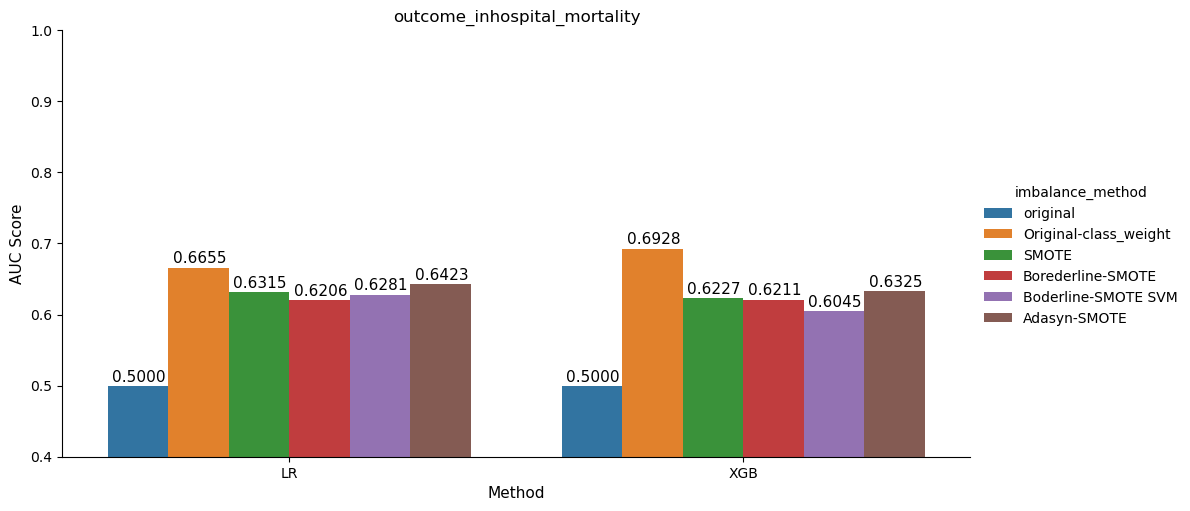

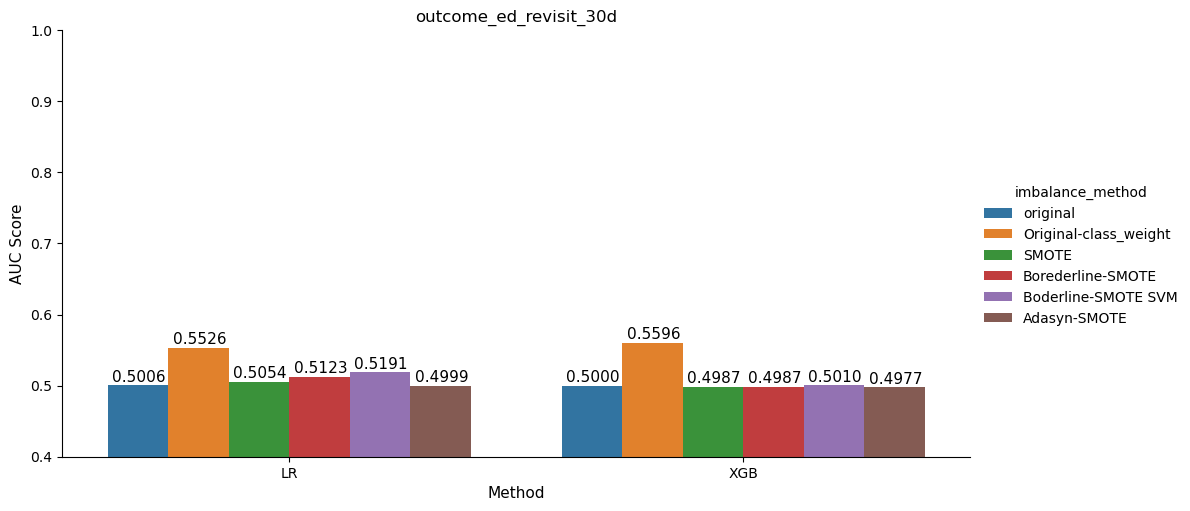

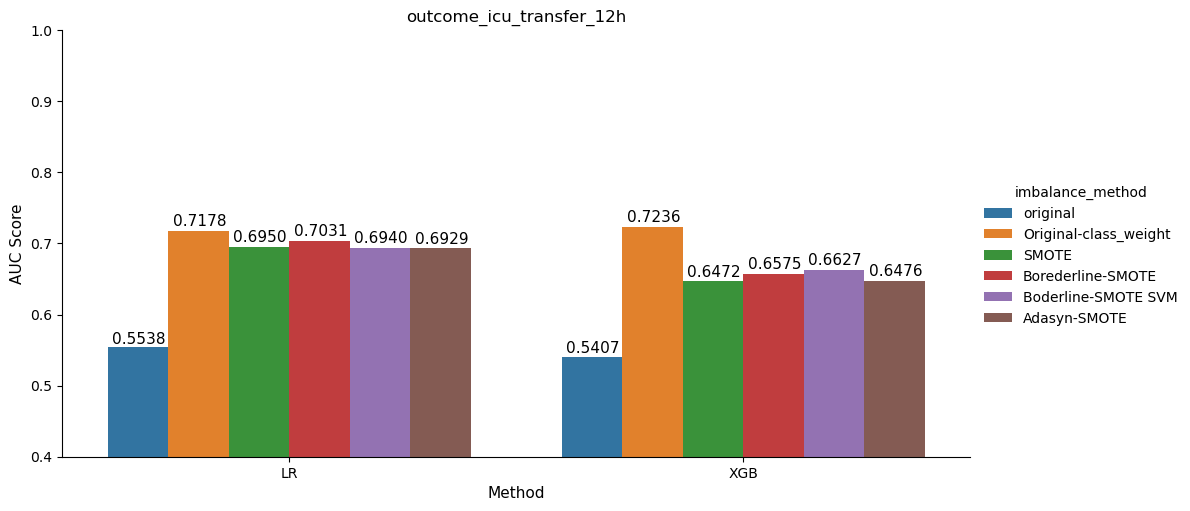

In [302]:
for outcome in outcomes:
    # print(outcome)
    bar = sns.catplot(x = "model_name",       # x variable name
                y = "auc",       # y variable name            
                data = summary_result[summary_result.outcome==outcome],     # dataframe to plot
                kind = "bar",
                hue = 'imbalance_method',
                height=5,
                aspect=5/2.5,
                ci = None)
    bar.set(title=outcome)
    ax = bar.facet_axis(0,0)
    for p in ax.patches:
        ax.text(p.get_x() + 0.01, 
                p.get_height() * 1.01, 
                '{0:.4f}'.format(p.get_height()), 
                color='black', rotation='horizontal', fontsize=11)

    # listOf_Yticks = np.arange(0.5, 0.7, 0.05)
    ax.set_ylim(0.4, 1)
    ax.set_ylabel('AUC Score', fontsize=11)
    ax.set_xlabel('Method', fontsize=11)
    ax

In [303]:
#between splits stability
for outcome in outcomes:
    print (outcome)
    print(summary_result[summary_result.outcome==outcome].groupby(['model_name', 'imbalance_method'])['auc'].std())
    

outcome_inhospital_mortality
model_name  imbalance_method     
LR          Adasyn-SMOTE             0.074519
            Boderline-SMOTE SVM      0.040361
            Borederline-SMOTE        0.036125
            Original-class_weight    0.082012
            SMOTE                    0.088474
            original                 0.000000
XGB         Adasyn-SMOTE             0.068614
            Boderline-SMOTE SVM      0.048712
            Borederline-SMOTE        0.050050
            Original-class_weight    0.058010
            SMOTE                    0.042902
            original                 0.000000
Name: auc, dtype: float64
outcome_ed_revisit_30d
model_name  imbalance_method     
LR          Adasyn-SMOTE             0.013869
            Boderline-SMOTE SVM      0.013256
            Borederline-SMOTE        0.010175
            Original-class_weight    0.026400
            SMOTE                    0.016547
            original                 0.001817
XGB         Adasyn-SMOTE  

# 3months

In [ ]:
#Create X set for model development

target_outcome = 'outcome_3months'
X = trainingData[features_columns]
y = trainingData[[target_outcome]]
print('X shape: ', X.shape)
print('y shape: ', y.shape)

#model parameters
params = {'xgb_lr': 0.6,
         'xgb_maxdepth': 7}

In [ ]:
%%time

#EXECUTE model training

kf = StratifiedKFold(n_splits=n_splits, random_state=1234, shuffle=True)
kf.get_n_splits(X)
models1 = pd.DataFrame(columns=['modelname', 'class_ratio'])
summary_result1 = []
cols = ['model_name', 'class_ratio', 'acc','spec','sens','auc', 'auprc', 'balance_accuracy', 'f1_score', 'ppv', 'npv']
split_counter = 0

#train model
for train_index, test_index in kf.split(X, y):
    #split data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    #Build models -> it can be commented if the models have been trained
    models_temp = pd.DataFrame(build_models(X_train, y_train[target_outcome], params, split_counter), columns=['modelname', 'class_ratio'])
    models1 = pd.concat([models1,models_temp]).reset_index(drop=True)
    split_counter+=1
        
#evaluate model
for modelname, classratio in models1.values:
    # print('======================================================================')
    print(modelname)
    model = pickle.load(open('./models/'+ target_outcome + '/'+ modelname + '.sav', 'rb'))
    summary_result1.append((str(model), classratio, ) + summariseResult (X_test, y_test[target_outcome], model) )       


summary_result1 = pd.DataFrame(summary_result1, columns=cols)
summary_result1['model_num'] = summary_result1.index



In [ ]:
print(target_outcome)
summary_result1['model_name'] = summary_result1.apply(lambda x: modelNameFixer(x.model_name), axis=1)
summary_result1.groupby('model_name').mean().sort_values(['auc'], ascending=False)

In [ ]:
summary_result1.to_csv("summaryResult_outcome1.csv")
summary_result1 = pd.read_csv("summaryResult_outcome1.csv")

bar = sns.catplot(x = "model_name",       # x variable name
            y = "auc",       # y variable name            
            data = summary_result1,     # dataframe to plot
            kind = "bar",
            height=5,
            aspect=5/2.5,
            ci = None)
ax = bar.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() + 0.01, 
            p.get_height() * 1.01, 
            '{0:.4f}'.format(p.get_height()), 
            color='black', rotation='horizontal', fontsize=11)
    
# listOf_Yticks = np.arange(0.5, 0.7, 0.05)
ax.set_ylim(0.4, 1)
ax.set_ylabel('AUC Score', fontsize=11)
ax.set_xlabel('Method', fontsize=11)

In [ ]:
# kf = StratifiedKFold(n_splits=2, random_state=1234, shuffle=True)
# kf.get_n_splits(X)
# for train_index, test_index in kf.split(X, y):
#     #split data
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#     trymodel = SVC(class_weight='balanced', C = 0.7, degree=2, kernel='poly', random_state=1234, cache_size=2048)
#     trymodel.fit(X_train,y_train)
#     print(summariseResult(X_test, y_test, trymodel))


In [ ]:
best_model1 = pickle.load(open('./models/outcome_3months/0DTModel.sav', 'rb'))

# pd.DataFrame([best_model3.feature_importances_], columns=X.columns).T.sort_values(0, ascending=False)
sorted_idx = best_model1.feature_importances_.argsort()
plt.figure(figsize=(5,7))
plt.barh(X.columns[sorted_idx][-10:], best_model1.feature_importances_[sorted_idx][-10:])
plt.xlabel("Decision Tree Feature Importance")
plt.show()

In [ ]:
best_model1 = pickle.load(open('./models/outcome_3months/0RFModel.sav', 'rb'))

# pd.DataFrame([best_model3.feature_importances_], columns=X.columns).T.sort_values(0, ascending=False)
sorted_idx = best_model1.feature_importances_.argsort()
plt.figure(figsize=(5,7))
plt.barh(X.columns[sorted_idx][-10:], best_model1.feature_importances_[sorted_idx][-10:])
plt.xlabel("Random Forest Feature Importance")
plt.show()

In [ ]:
best_model1 = pickle.load(open('./models/outcome_3months/0XGBoostModel.sav', 'rb'))

# pd.DataFrame([best_model3.feature_importances_], columns=X.columns).T.sort_values(0, ascending=False)
sorted_idx = best_model1.feature_importances_.argsort()
plt.figure(figsize=(5,7))
plt.barh(X.columns[sorted_idx][-10:], best_model1.feature_importances_[sorted_idx][-10:])
plt.xlabel("XGBoost Feature Importance")
plt.show()

# 6months

In [ ]:
target_outcome = 'outcome_combined_6months'
y = trainingData[[target_outcome]]

#model parameters
params = {'xgb_lr': 0.6,
         'xgb_maxdepth': 7}

In [ ]:
%%time

#EXECUTE model training

kf = StratifiedKFold(n_splits=n_splits, random_state=1234, shuffle=True)
kf.get_n_splits(X)
models2 = pd.DataFrame(columns=['modelname', 'class_ratio'])
summary_result2 = []
cols = ['model_name', 'class_ratio', 'acc','spec','sens','auc', 'auprc', 'balance_accuracy', 'f1_score', 'ppv', 'npv']
split_counter = 0

#train model
for train_index, test_index in kf.split(X, y):
    #split data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    #Build models -> it can be commented if the models have been trained
    models_temp = pd.DataFrame(build_models(X_train, y_train[target_outcome], params, split_counter), columns=['modelname', 'class_ratio'])
    models2 = pd.concat([models2,models_temp]).reset_index(drop=True)
    split_counter+=1
        
#evaluate model
for modelname, classratio in models2.values:
    # print('======================================================================')
    print(modelname)
    model = pickle.load(open('./models/'+ target_outcome + '/'+ modelname + '.sav', 'rb'))
    summary_result2.append((str(model), classratio, ) + summariseResult (X_test, y_test[target_outcome], model) )       


summary_result2 = pd.DataFrame(summary_result2, columns=cols)
summary_result2['model_num'] = summary_result2.index
# summary_result1['method_name'] = summary_result1.apply(lambda x: 'LR' if x.model_num%2 == 0 else 'XGBoost', axis=1)


In [ ]:
print(target_outcome)
summary_result2['model_name'] = summary_result2.apply(lambda x: modelNameFixer(x.model_name), axis=1)
summary_result2.groupby('model_name').mean().sort_values(['auc'], ascending=False)

In [ ]:
summary_result2.to_csv("summaryResult_outcome2.csv")
summary_result2 = pd.read_csv("summaryResult_outcome2.csv")

bar = sns.catplot(x = "model_name",       # x variable name
            y = "auc",       # y variable name            
            data = summary_result2,     # dataframe to plot
            kind = "bar",
            height=5,
            aspect=5/2.5,
            ci = None)
ax = bar.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() + 0.01, 
            p.get_height() * 1.01, 
            '{0:.4f}'.format(p.get_height()), 
            color='black', rotation='horizontal', fontsize=11)
    
# listOf_Yticks = np.arange(0.5, 0.7, 0.05)
ax.set_ylim(0.4, 1)
ax.set_ylabel('AUC Score', fontsize=11)
ax.set_xlabel('Method', fontsize=11)

In [ ]:
best_model2 = pickle.load(open('./models/outcome_combined_6months/0DTModel.sav', 'rb'))

# pd.DataFrame([best_model3.feature_importances_], columns=X.columns).T.sort_values(0, ascending=False)
sorted_idx = best_model2.feature_importances_.argsort()
plt.figure(figsize=(5,7))
plt.barh(X.columns[sorted_idx][-10:], best_model2.feature_importances_[sorted_idx][-10:])
plt.xlabel("Decision Tree Feature Importance")
plt.show()

In [ ]:
best_model2 = pickle.load(open('./models/outcome_combined_6months/0RFModel.sav', 'rb'))

# pd.DataFrame([best_model3.feature_importances_], columns=X.columns).T.sort_values(0, ascending=False)
sorted_idx = best_model2.feature_importances_.argsort()
plt.figure(figsize=(5,7))
plt.barh(X.columns[sorted_idx][-10:], best_model2.feature_importances_[sorted_idx][-10:])
plt.xlabel("Random Forest Feature Importance")
plt.show()

In [ ]:
best_model2 = pickle.load(open('./models/outcome_combined_6months/0XGBoostModel.sav', 'rb'))

# pd.DataFrame([best_model3.feature_importances_], columns=X.columns).T.sort_values(0, ascending=False)
sorted_idx = best_model2.feature_importances_.argsort()
plt.figure(figsize=(5,7))
plt.barh(X.columns[sorted_idx][-10:], best_model2.feature_importances_[sorted_idx][-10:])
plt.xlabel("XGBoost Feature Importance")
plt.show()

# 12 months

In [ ]:
target_outcome = 'outcome_combined_12months'
y = trainingData[[target_outcome]]

#model parameters
params = {'xgb_lr': 0.6,
         'xgb_maxdepth': 10}

In [ ]:
%%time

#EXECUTE model training

kf = StratifiedKFold(n_splits=n_splits, random_state=1234, shuffle=True)
kf.get_n_splits(X)
models3 = pd.DataFrame(columns=['modelname', 'class_ratio'])
summary_result3 = []
cols = ['model_name', 'class_ratio', 'acc','spec','sens','auc', 'auprc', 'balance_accuracy', 'f1_score', 'ppv', 'npv']
split_counter = 0

#train model
for train_index, test_index in kf.split(X, y):
    #split data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    #Build models -> it can be commented if the models have been trained
    models_temp = pd.DataFrame(build_models(X_train, y_train[target_outcome], params, split_counter), columns=['modelname', 'class_ratio'])
    models3 = pd.concat([models3,models_temp]).reset_index(drop=True)
    split_counter+=1
        
#evaluate model
for modelname, classratio in models3.values:
    # print('======================================================================')
    print(modelname)
    model = pickle.load(open('./models/'+ target_outcome + '/'+ modelname + '.sav', 'rb'))
    summary_result3.append((str(model), classratio, ) + summariseResult (X_test, y_test[target_outcome], model) )       


summary_result3 = pd.DataFrame(summary_result3, columns=cols)
summary_result3['model_num'] = summary_result3.index
# summary_result1['method_name'] = summary_result1.apply(lambda x: 'LR' if x.model_num%2 == 0 else 'XGBoost', axis=1)


In [ ]:
print(target_outcome)
summary_result3['model_name'] = summary_result3.apply(lambda x: modelNameFixer(x.model_name), axis=1)
summary_result3.groupby('model_name').mean().sort_values(['auc'], ascending=False)

In [ ]:
summary_result3.to_csv("summaryResult_outcome3.csv")
summary_result3 = pd.read_csv("summaryResult_outcome3.csv")

bar = sns.catplot(x = "model_name",       # x variable name
            y = "auc",       # y variable name            
            data = summary_result3,     # dataframe to plot
            kind = "bar",
            height=5,
            aspect=5/2.5,
            ci = None)
ax = bar.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() + 0.01, 
            p.get_height() * 1.01, 
            '{0:.4f}'.format(p.get_height()), 
            color='black', rotation='horizontal', fontsize=11)
    
# listOf_Yticks = np.arange(0.5, 0.7, 0.05)
ax.set_ylim(0.4, 1)
ax.set_ylabel('AUC Score', fontsize=11)
ax.set_xlabel('Method', fontsize=11)

In [ ]:
best_model3 = pickle.load(open('./models/outcome_combined_12months/0DTModel.sav', 'rb'))

# pd.DataFrame([best_model3.feature_importances_], columns=X.columns).T.sort_values(0, ascending=False)
sorted_idx = best_model3.feature_importances_.argsort()
plt.figure(figsize=(5,7))
plt.barh(X.columns[sorted_idx][-10:], best_model3.feature_importances_[sorted_idx][-10:])
plt.xlabel("Decision Tree Feature Importance")
plt.show()

In [ ]:
best_model3 = pickle.load(open('./models/outcome_combined_12months/0RFModel.sav', 'rb'))

# pd.DataFrame([best_model3.feature_importances_], columns=X.columns).T.sort_values(0, ascending=False)
sorted_idx = best_model3.feature_importances_.argsort()
plt.figure(figsize=(5,7))
plt.barh(X.columns[sorted_idx][-10:], best_model3.feature_importances_[sorted_idx][-10:])
plt.xlabel("Random Forest Feature Importance")
plt.show()

In [ ]:
best_model3 = pickle.load(open('./models/outcome_combined_12months/0XGBoostModel.sav', 'rb'))

# pd.DataFrame([best_model3.feature_importances_], columns=X.columns).T.sort_values(0, ascending=False)
sorted_idx = best_model3.feature_importances_.argsort()
plt.figure(figsize=(5,7))
plt.barh(X.columns[sorted_idx][-10:], best_model3.feature_importances_[sorted_idx][-10:])
plt.xlabel("XGBoost Feature Importance")
plt.show()